Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import copy
from google.colab import drive

drive.mount('/content/drive/')
models_base_path = 'drive/MyDrive/GMDL_hw5_models/'
plots_base_path = 'drive/MyDrive/GMDL_hw5_plots/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Computer Exercise 1 - Load data using PyTorch**

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 64

trainsetfull = datasets.SVHN(root='./data', split='train', 
                             download=True, transform=transform)
train_size = int(0.8 * len(trainsetfull))
validation_size = len(trainsetfull) - train_size
testset = datasets.SVHN(root='./data', split='test', 
                        download=True, transform=transform)
trainset, validationset = random_split(trainsetfull, 
                                       [train_size, validation_size])

trainloader = DataLoader(trainset, batch_size=batch_size, 
                         shuffle=True, num_workers=2)

validationloader = DataLoader(validationset, batch_size=batch_size, 
                              shuffle=False, num_workers=2)

testloader = DataLoader(testset, batch_size=batch_size, 
                         shuffle=False, num_workers=2)

dataloaders = dict()
dataloaders['train'] = trainloader
dataloaders['val'] = validationloader
dataset_sizes = dict()
dataset_sizes['train'] = train_size
dataset_sizes['val'] = validation_size

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


Show 5 random images from the train set

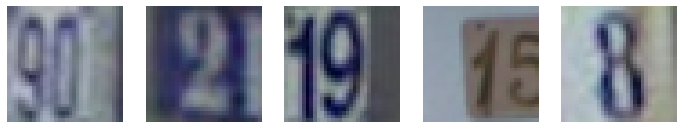

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
figure = plt.figure(figsize=(12, 12))
for i in range(1, 6):
  plt.subplot(1, 5, i)
  plt.axis('off')
  plt.imshow(transforms.ToPILImage()(images[i]))

# **Computer Exercise 2**

Fully-connected neural network class

In [ ]:
input_size = 32 * 32 * 3
output_size = 10

class FC_Net(nn.Module):
  def __init__(self, hidden1_size=128, hidden2_size=64):
    super(FC_Net, self).__init__()
    self.hidden1_size = hidden1_size
    self.hidden2_size = hidden2_size
    self.input = nn.Linear(input_size, hidden1_size)
    self.hidden1 = nn.Linear(hidden1_size, hidden2_size)
    self.hidden2 = nn.Linear(hidden2_size, output_size)

  # x represents our data
  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)
    x = self.hidden1(x)
    x = F.relu(x)
    x = self.hidden2(x)
    return x

Convolutional neural network class

In [ ]:
input_channels = 3
hidden_channels = [10, 20]
cnn_fc_size = 64

class CNN(nn.Module):
  def __init__(self, kernel_size=3):
    super(CNN, self).__init__()

    # Calculate convolutions output size
    conv1_output_size = ((32 - kernel_size + 3) // 2)
    conv2_output_size = ((conv1_output_size - kernel_size + 3) // 2)
    conv_output_size = conv2_output_size ** 2

    self.kernel_size = kernel_size
    self.conv1 = nn.Conv2d(input_channels, hidden_channels[0], 
                           kernel_size, 1, 1)
    self.conv2 = nn.Conv2d(hidden_channels[0], hidden_channels[1], 
                           kernel_size, 1, 1)
    self.fc1 = nn.Linear(conv_output_size * hidden_channels[1], cnn_fc_size)
    self.fc2 = nn.Linear(cnn_fc_size, output_size)

  # x represents our data
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# **Computer Exercise 3 - Training**

In [ ]:
def plot_stats(values, num_epochs, filename, params,is_loss=True, is_fc=True, 
               is_ft=False):
  title = f'FC network {params[0]}, {params[1]}\n' if is_fc \
    else f'CNN with kernel size {params[0]}\n' if not is_ft \
    else f'ResNet-18 finetuned with lr={params[0]}\n'
  title += 'Loss per Epoch' if is_loss else 'Accuracy per Epoch'
  plt.plot(range(num_epochs), values['train'], label='Train')
  plt.plot(range(num_epochs), values['val'], label='Validation')
  plt.title(title)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss' if is_loss else 'Accuracy')
  plt.savefig(f'{plots_base_path}{filename}.png')
  plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, dataloaders, model_name,
                num_epochs=30, is_fc=True, is_ft=False):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  losses = {'train': [], 'val': []}
  accuracy = {'train': [], 'val': []}
  params = [model.hidden1_size, model.hidden2_size] if is_fc \
    else [model.kernel_size] if not is_ft else [optimizer.param_groups[0]['lr']]

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
          model.train()  # Set model to training mode
      else:
          model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        if is_fc:
          inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          logits = model(inputs)    # forward pass
          _, preds = torch.max(logits, 1)

          loss = criterion(logits, labels)    # calculate loss

          if phase == 'train':
            loss.backward()   # backpropogation to compute the gradients
            optimizer.step()  # updates the weights

          # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(
          phase, epoch_loss, epoch_acc))
        
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

      losses[phase].append(epoch_loss)
      accuracy[phase].append(epoch_acc.to('cpu'))
  
  model.load_state_dict(best_model_wts)
  plot_stats(losses, num_epochs, f'Loss_{model_name}', params, is_fc=is_fc, 
             is_ft=is_ft)
  plot_stats(accuracy, num_epochs, f"Acc_{model_name}", params, is_loss=False,
             is_fc=is_fc, is_ft=is_ft)
  return model, best_acc

In [ ]:
best_validation_acc = 0.0
best_model_path = ''
is_best_fc = True

# Train FC network
print('Train FC network with hidden layers of size 128, 64')
print('-' * 10)

fcNet = FC_Net()
optimizer_fc = optim.Adam(fcNet.parameters(), lr=0.001)

fcNet.to(device)

fc_model_name = f'fc_{fcNet.hidden1_size}_{fcNet.hidden2_size}'
fcNet, fc_best_val_acc = train_model(fcNet, nn.CrossEntropyLoss(), optimizer_fc, 
                                  dataloaders, fc_model_name)
torch.save(fcNet.state_dict(), 
           models_base_path + f'{fc_model_name}.pth')

if fc_best_val_acc > best_validation_acc:
  best_validation_acc = fc_best_val_acc
  is_best_fc = True
  best_model_path = models_base_path + f'{fc_model_name}.pth'


Train FC network with hidden layers of size 128, 64
----------
Epoch 1/30
----------
train Loss: 2.1613 Acc: 0.2152

val Loss: 2.0451 Acc: 0.2579

Epoch 2/30
----------
train Loss: 1.9274 Acc: 0.3164

val Loss: 1.7913 Acc: 0.3713

Epoch 3/30
----------
train Loss: 1.7386 Acc: 0.3897

val Loss: 1.6930 Acc: 0.4094

Epoch 4/30
----------
train Loss: 1.6989 Acc: 0.4054

val Loss: 1.6987 Acc: 0.4032

Epoch 5/30
----------
train Loss: 1.6703 Acc: 0.4125

val Loss: 1.6768 Acc: 0.4092

Epoch 6/30
----------
train Loss: 1.6288 Acc: 0.4252

val Loss: 1.5585 Acc: 0.4587

Epoch 7/30
----------
train Loss: 1.4829 Acc: 0.4904

val Loss: 1.4547 Acc: 0.5074

Epoch 8/30
----------
train Loss: 1.4291 Acc: 0.5128

val Loss: 1.4165 Acc: 0.5277

Epoch 9/30
----------
train Loss: 1.4131 Acc: 0.5204

val Loss: 1.3949 Acc: 0.5360

Epoch 10/30
----------
train Loss: 1.3979 Acc: 0.5264

val Loss: 1.3909 Acc: 0.5382

Epoch 11/30
----------
train Loss: 1.3852 Acc: 0.5342

val Loss: 1.3954 Acc: 0.5331

Epoch 12/30

In [ ]:
# Train CNN
print('Train CNN with kernel size 3')
print('-' * 10)

cnn = CNN()
optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.001)

cnn.to(device)

cnn_model_name = f'cnn_{cnn.kernel_size}'
cnn, cnn_best_val_acc = train_model(cnn, nn.CrossEntropyLoss(), optimizer_cnn, 
                                    dataloaders, cnn_model_name,is_fc=False)
torch.save(cnn.state_dict(), 
           models_base_path + f'{cnn_model_name}.pth')

if cnn_best_val_acc > best_validation_acc:
  best_validation_acc = cnn_best_val_acc
  is_best_fc = False
  best_model_path = models_base_path + f'{cnn_model_name}.pth'

# **Computer exercise 4 - Hyperparameters search**

In [ ]:
# Comparing different hidden layer sizes for FC network

fc_params = [[512, 256], [64, 32]]

for hidden_sizes in fc_params:
  print()
  print(f'Train FC network with hidden layers of size \
    {hidden_sizes[0]}, {hidden_sizes[1]}')
  print('-' * 10)

  fcNet = FC_Net(hidden_sizes[0], hidden_sizes[1])
  optimizer_fc = optim.Adam(fcNet.parameters(), lr=0.001)
  fcNet.to(device)
  fc_model_name = f'fc_{fcNet.hidden1_size}_{fcNet.hidden2_size}'
  fcNet, curr_best_val_acc = train_model(fcNet, nn.CrossEntropyLoss(), 
                                         optimizer_fc, dataloaders, 
                                         fc_model_name)
  
  torch.save(fcNet.state_dict(), 
            models_base_path + f'{fc_model_name}.pth')
  
  if curr_best_val_acc > best_validation_acc:
    best_validation_acc = curr_best_val_acc
    is_best_fc = True
    best_model_path = models_base_path + f'{fc_model_name}.pth'
  
# Comparing different kernel sizes for CNN
cnn_kernel_sizes = [10, 1]
for kernel_size in cnn_kernel_sizes:
  print()
  print(f'Train CNN with kernel size {kernel_size}')
  print('-' * 10)

  cnn = CNN(kernel_size)
  optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.001)
  cnn.to(device)
  cnn_model_name = f'cnn_{cnn.kernel_size}'
  cnn, curr_best_val_acc = train_model(cnn, nn.CrossEntropyLoss(), 
                                       optimizer_cnn, dataloaders, 
                                       cnn_model_name,is_fc=False)
  
  torch.save(cnn.state_dict(), 
            models_base_path + f'{cnn_model_name}.pth')  

  if curr_best_val_acc > best_validation_acc:
    best_validation_acc = curr_best_val_acc
    is_best_fc = False
    best_model_path = models_base_path + f'{cnn_model_name}.pth'

## **Problem 1**

The architecture which performed best in our experiment was the CNN with kernel size of 3.

This architecture achived train loss of 0.2322 and train accuracy of 93.14%, and validation loss of 0.498 with validation accuracy of 87.61%.

In terms of overfitting and based on the validation set, we can observe a minor overfitting as starting from epoch 5 we see the losses of the train and validation start to diverge, and reach a difference of about 0.25 between the train loss and the validation loss (train loss is lower). This indicates a small overfitting.

# **Computer exercise 5 - Test best model**

In [ ]:
def evaluate_model(model, dataloader, is_fc=True):
  correct_count, all_count = 0, 0
  with torch.no_grad():
    for inputs, labels in dataloader:
      if is_fc:
        inputs = inputs.view(inputs.shape[0], -1)
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      correct_pred = torch.eq(labels, preds).cpu()
      correct_count += correct_pred.numpy().sum()
      all_count += len(labels)
  
  print(f'Number of images tested: {all_count}')
  print(f'\nModel test accuracy: {correct_count / all_count}')

In [ ]:
# Load best model parameters
best_model = FC_Net() if is_best_fc else CNN()
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model_type = 'FC' if is_best_fc else 'CNN'
best_model_params = f'with {best_model.hidden1_size}, {best_model.hidden2_size}'\
 if is_best_fc else f'with kernel size {best_model.kernel_size}'
print(f'\nBest model is {best_model_type} {best_model_params}')
print('Testing best model...\n')
evaluate_model(best_model, testloader, is_fc=is_best_fc)

## **Problem 2**

We can't guarantee that the model which performed best on the validation set will also be the model which performs best on the test set, as it depends on the similarity between the test and validation data sets in terms of the data set size, distribution and versatility (different kinds of examples).

However, it is likely to perform similar to the way it performed on the validation set, assuming we divided our data in an appropriate way for training a model.

The basic assumption we made using the validation set to choose the hyper-parameters was that the validation set is similar to the test set in terms of data distribution, thus the performence on the validation set will indicate how good our model generalizes the problem.

# **Computer exercise 6 - Tranfer learning**

Fine tune ResNet-18:

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

print('Finetuning ResNet-18 with lr=0.001')
print('-' * 10)

model_ft, _ = train_model(model_ft, nn.CrossEntropyLoss(), 
                       optimizer_ft, dataloaders,'resnet_18_ft_lr=0.001', 
                       is_fc=False, is_ft=True)

torch.save(model_ft.state_dict(), models_base_path + 'resnet18_ft.pth')
evaluate_model(model_ft, testloader, is_fc=False)

## **Problem 3**

We chose to finetune the ResNet, because we figured that the problem of classifying ImageNet dataset is a bit different from the problem which we try to solve, as detecting "types" (classes) of different objects is different from detecting a digit from a cropped street sign image. Thus, we thought it would be a better idea to train the model again to adapt it to our problem, while initializing the weights with the pretrained ResNet as it's well trained in extracting image features already.

## **Problem 4**

The new finetuned ResNet network performs much better on the validation and test datasets.

Validation accuracy:
*   Our best model: 87.61%
*   ResNet-18 finetuned: 92.93


Test accuracy:
*   Our best model: 86.17%
*   ResNet-18 finetuned: 93.02%



We believe it's due to the fact that we did 'smart initialization' of the model's weights and used a model which is already trained well on extracting image features and classifying objects. This fact, alongside the finetuning we did in the training process caused the model to perform better.

One thing to note is that the training process took longer in the finetuned ResNet as the architecture of the network is more complex than the networks we've built.

## **Problem 5**

In [ ]:
for lr in [0.1, 0.005, 0.0001]:
  model_ft = models.resnet18(pretrained=True)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, 10)
  model_ft = model_ft.to(device)
  optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr)
  print()
  print(f'Finetuning ResNet-18 with lr={lr}')
  print('-' * 10)
  model_ft = train_model(model_ft, nn.CrossEntropyLoss(), 
                       optimizer_ft, dataloaders, f'resnet_18_ft_lr={lr}', 
                       is_fc=False, is_ft=True)

We experimented with 3 other learning rates as can be seen above. The results were:


*   For a large learning rate (`lr=1`), we see that the optimization process diverged and we got poor results. We assume this is due to the fact that the learning rate was too large.
*   For a similar learning rate (although 5 times larger, `lr=0.005`), we observed similar results to the original learning rate (`lr=0.001`), so it seems like multiplying the learning rate didn't have much effect.
*   For a small learning rate (`lr=0.0001`), we see a little bit less overfitting, but not so much that makes a difference in the results, as we still got about 92% validation accuracy.




